In [ ]:
import torch
from torch import nn
import numpy as np
import gym
import matplotlib.pyplot as plt

class CEM(nn.Module):
    def __init__(self, state_dim, action_n):
        super().__init__()
        self.state_dim = state_dim
        self.action_n = action_n

        self.network = nn.Sequential(
            nn.Linear(self.state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, self.action_n)
        )

        self.softmax = nn.Softmax(dim=1)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, _input):
        return self.network(_input)

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        logits = self.forward(state)
        action_prob = self.softmax(logits).detach().numpy().flatten()
        action = np.random.choice(self.action_n, p=action_prob)
        return action

    def update_policy(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        elite_states = torch.FloatTensor(elite_states)
        elite_actions = torch.LongTensor(elite_actions)

        loss = self.loss(self.forward(elite_states), elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

def get_trajectory(env, agent, trajectory_len, visualize=False):
    trajectory = {'states':[], 'actions': [], 'total_reward': 0}

    state = env.reset()
    trajectory['states'].append(state)

    for _ in range(trajectory_len):

        action = agent.get_action(state)
        trajectory['actions'].append(action)

        state, reward, done, _ = env.step(action)
        trajectory['total_reward'] += reward

        if done:
            break

        if visualize:
            env.render()

        trajectory['states'].append(state)

    return trajectory

def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param)
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]

env = gym.make('Acrobot-v1')
state_dim = env.observation_space.shape[0]
action_n = env.action_space.n

agent = CEM(state_dim, action_n)
episode_n = 100
trajectory_n = 200
trajectory_len = 500
q_param = 0.7
scores = []
for episode in range(episode_n):
    trajectories = [get_trajectory(env, agent, trajectory_len) for _ in range(trajectory_n)]

    mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
    print(f'episode: {episode}, mean_total_reward = {mean_total_reward}')
    scores.append(mean_total_reward)
    elite_trajectories = get_elite_trajectories(trajectories, q_param)

    if len(elite_trajectories) > 0:
        agent.update_policy(elite_trajectories)

res = get_trajectory(env, agent, trajectory_len, visualize=False)

episode: 0, mean_total_reward = -500.0
episode: 1, mean_total_reward = -499.385
episode: 2, mean_total_reward = -155.675
episode: 3, mean_total_reward = -104.3
episode: 4, mean_total_reward = -86.22
episode: 5, mean_total_reward = -86.625
episode: 6, mean_total_reward = -83.495
episode: 7, mean_total_reward = -83.725
episode: 8, mean_total_reward = -87.865
episode: 9, mean_total_reward = -82.765
episode: 10, mean_total_reward = -85.255
episode: 11, mean_total_reward = -81.665
episode: 12, mean_total_reward = -81.93
episode: 13, mean_total_reward = -83.01
episode: 14, mean_total_reward = -81.785
episode: 15, mean_total_reward = -82.285
episode: 16, mean_total_reward = -84.0
episode: 17, mean_total_reward = -80.95
episode: 18, mean_total_reward = -82.52
episode: 19, mean_total_reward = -78.195
episode: 20, mean_total_reward = -81.66
episode: 21, mean_total_reward = -80.7
episode: 22, mean_total_reward = -79.64
episode: 23, mean_total_reward = -79.015
episode: 24, mean_total_reward = -78.

{'states': [array([ 0.9983636 , -0.05718431,  0.99992716,  0.01206723, -0.0139981 ,
         -0.04750329], dtype=float32),
  array([ 0.99781895, -0.06601039,  0.9995319 ,  0.03059371, -0.07193991,
          0.22798863], dtype=float32),
  array([ 0.99645495, -0.08412828,  0.99508584,  0.09901614, -0.10377431,
          0.4428731 ], dtype=float32),
  array([ 0.9945275 , -0.10447476,  0.9800353 ,  0.19882351, -0.09311574,
          0.54608595], dtype=float32),
  array([ 0.9929905 , -0.11819418,  0.95271224,  0.303874  , -0.0388079 ,
          0.5194368 ], dtype=float32),
  array([ 0.99301267, -0.11800779,  0.9208907 ,  0.38982093,  0.04298226,
          0.38289124], dtype=float32),
  array([ 0.9948814 , -0.10104946,  0.89711356,  0.4418    ,  0.1252205 ,
          0.1830529 ], dtype=float32),
  array([ 0.99755096, -0.06994357,  0.8901753 ,  0.45561823,  0.18068315,
         -0.02550151], dtype=float32),
  array([ 0.9999777 , -0.00667785,  0.927195  ,  0.37457892,  0.43847093,
         -0.

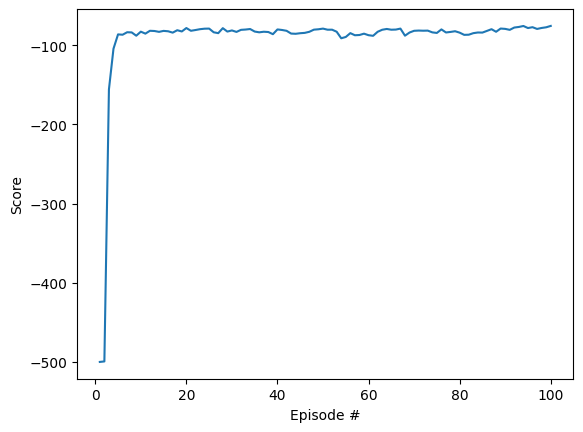

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
print(scores)

[-500.0, -500.0, -500.0, -500.0, -500.0, -500.0, -500.0, -500.0, -492.05, -124.1, -89.7, -105.6, -98.35, -98.25, -81.4, -80.7, -79.25, -75.75, -94.65, -96.25, -92.9, -83.9, -86.05, -85.55, -88.8, -87.1, -81.55, -85.6, -89.45, -124.1, -121.7, -111.7, -134.7, -134.95, -159.45, -124.15, -134.1, -117.4, -125.0, -109.65, -99.5, -91.6, -89.3, -84.95, -87.5, -81.35, -82.05, -83.8, -78.2, -92.15, -87.7, -84.2, -89.2, -86.25, -138.7, -95.55, -141.45, -164.75, -235.25, -209.95, -168.2, -224.15, -178.25, -172.0, -144.3, -127.6, -189.15, -121.95, -208.1, -229.25, -203.05, -117.3, -113.85, -124.5, -123.6, -87.15, -88.1, -99.6, -82.45, -85.15, -94.1, -81.85, -81.6, -81.8, -77.55, -86.5, -80.65, -86.75, -82.6, -79.35, -81.75, -94.45, -83.3, -91.45, -80.95, -89.4, -79.45, -92.55, -87.8, -82.65, -87.1, -82.55, -81.65, -85.7, -87.05, -84.55, -82.7, -79.05, -81.7, -84.05, -84.35, -94.5, -84.65, -81.4, -83.55, -81.1, -85.9, -79.35, -91.7, -98.05, -80.35, -89.35, -88.9, -87.9, -102.3, -88.35, -83.2, -87.05